In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import mlflow 
import mlflow.pytorch
from datetime import datetime
import os

### 1. Load the dataset ###

In [ ]:
df = pd.read_csv('../data/ETTm1.csv')

NameError: name 'pd' is not defined

### 2. Exploratory Data Analysis ###

In [64]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [65]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
25%,5.827000,0.804000,3.305000,-0.284000,2.315000,0.670000,6.964000
50%,8.841000,2.210000,6.005000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.655000,1.218000,18.079000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [ ]:
#change datatype of date column
df['date'] = pd.to_datetime(df['date'])

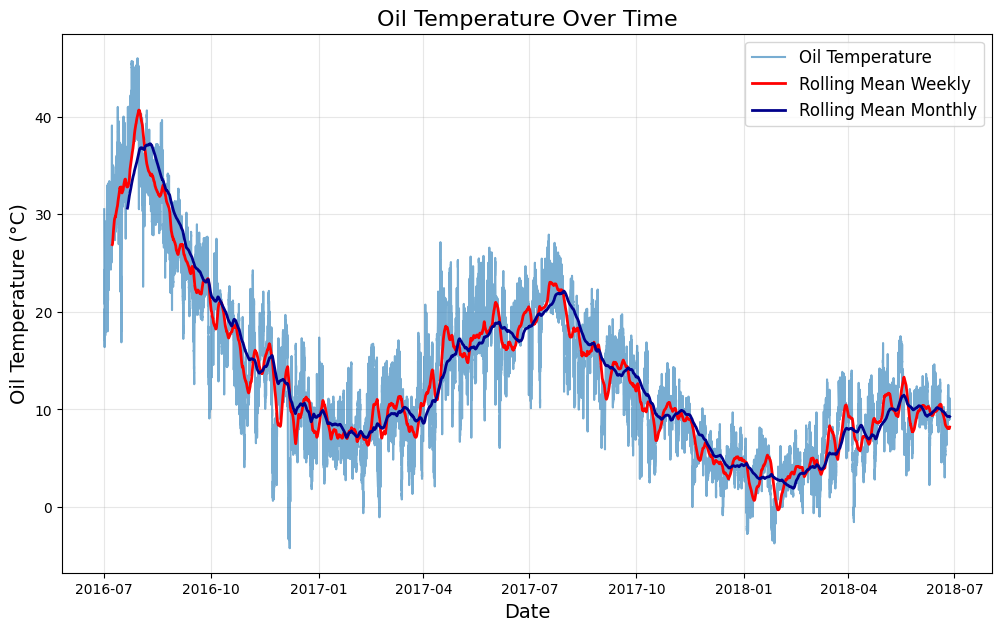

In [ ]:
#plot the trajectory of the target variable including weekly and 20 day rolling windows
rolling_mean_week = df['OT'].rolling(window=4*24*7).mean() #weekly rolling window
rolling_mean_month = df['OT'].rolling(window=4*24*20).mean()

#plot the rollings 
plt.figure(figsize=(12, 7))

plt.plot(df['date'], df['OT'], label='Oil Temperature', alpha=0.6)
plt.plot(df['date'], rolling_mean_week, label='Rolling Mean Weekly', color='red', linewidth=2)
plt.plot(df['date'], rolling_mean_month, label='Rolling Mean Monthly', color='darkblue', linewidth=2)


plt.title('Oil Temperature Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Oil Temperature (°C)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

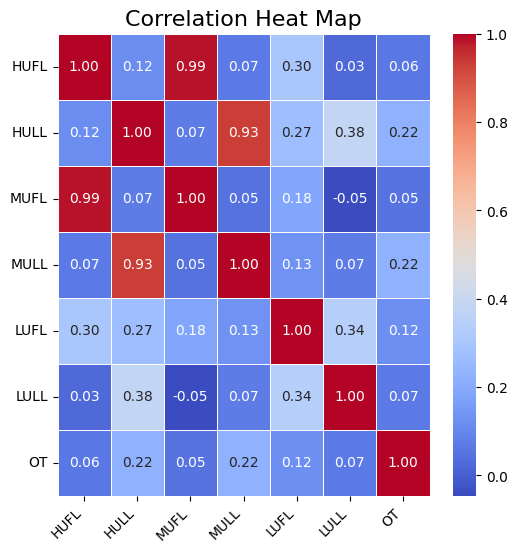

In [ ]:
#generate a correlcation matrix, to get first inidces which variables will have a bigger influence
correlations = df.iloc[:,1:].corr()

plt.figure(figsize=(6, 6))  
sns.heatmap(
    correlations, 
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    linewidths=0.5,    
    cbar=True          
)

plt.title("Correlation Heat Map", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)               
plt.show()

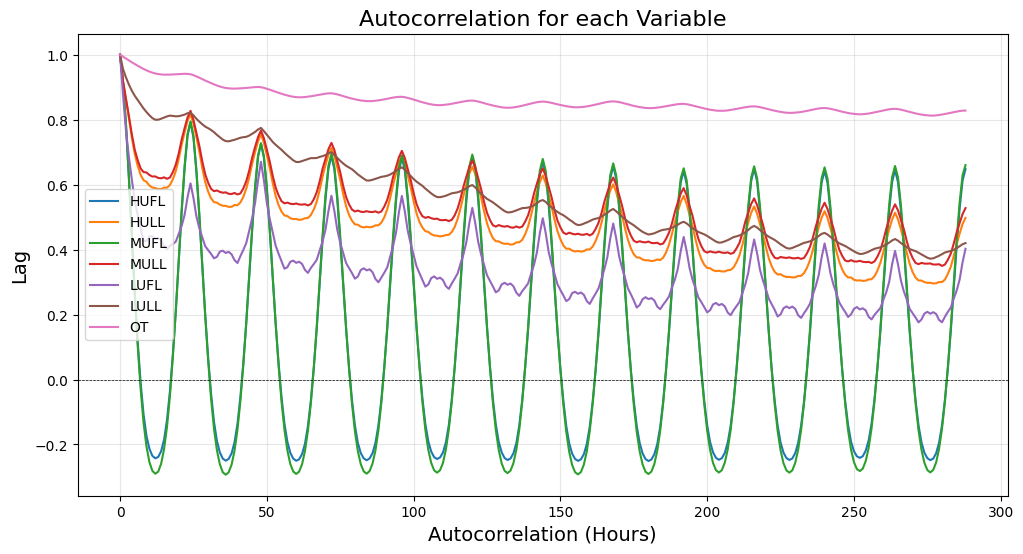

In [ ]:
#gernerate a plot of the autocorrelation of all variables
plt.figure(figsize=(12, 6))

for column in df.columns[1:]:
    var = df[column]
    var = var[::4]
    autocorr = acf(var, nlags=24*12)
    plt.plot(range(len(autocorr)), autocorr, label=column)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Autocorrelation (Hours)', fontsize=14)
plt.ylabel('Lag', fontsize=14)
plt.title('Autocorrelation for each Variable', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### 3. Do a train test split ###

In [ ]:
#create a new dataset class, designed for sequential data
class ETDataset(Dataset):
    def __init__(self, df, sequence_length=24, targe_column = 'OT'):
        self.sequence_length = sequence_length
        
        feature_cols = df.drop([targe_column, 'date'], axis=1).columns
        self.features = df[feature_cols].values
        self.target = df[targe_column].values

        self.data = []
        self.pred = []

        for i in range(len(self.features) - sequence_length):
            self.data.append(self.features[i:i+sequence_length])
            self.pred.append(self.target[i+sequence_length])

        self.data = np.array(self.data, dtype=np.float32)
        self.pred = np.array(self.pred, dtype=np.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32), torch.tensor(self.pred[index], dtype=torch.float32)

dataset = ETDataset(df)

In [ ]:
#define split rations
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths for each subset
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 55724
Testing set size: 13932


### 4a ) Built a baseline model ###

In [73]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x):
        return x[ -1 ,-1]

baseline_model = BaselineModel()
baseline_model(df.iloc[:1].values)

30.5310001373291

### 4b), 4e) Define some simple and stacked RNN ###
The stacked version can be generated my setting num_layers > 1

In [74]:
class SimpleRNN(nn.Module):
    def __init__(self, num_inputs, hidden_size, num_layers, dropout = 0):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=num_inputs,  hidden_size=hidden_size,num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        _ , hidden = self.rnn(x)
        y = self.linear(hidden[-1])
        return y

### 4c) Define a GRU manually ###

In [ ]:
#define a GRU cell that will be implementet into the model later
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()

        #define weigths for reset gate
        self.reset_x = nn.Linear(input_size, hidden_size)
        self.reset_h = nn.Linear(hidden_size, hidden_size)

        #define weigths for update gate
        self.update_x = nn.Linear(input_size, hidden_size)
        self.update_h = nn.Linear(hidden_size, hidden_size)

        #define weigts for candidate hidden state
        self.candidate_x = nn.Linear(input_size, hidden_size)
        self.candidate_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        #reset gate
        r = F.sigmoid(self.reset_x(x) + self.reset_h(h))

        #update gate
        z = F.sigmoid(self.update_x(x) + self.update_h(h))

        #candidate hidden state
        h_snake = F.tanh(self.candidate_x(x) + self.candidate_h(r*h))

        h = z*h + (1-z)*h_snake

        return h

#define the GRU model to handle the whole sequence
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru_cell = GRUCell(input_size, hidden_size)
        self.regressor = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        sequence_length = x.shape[1]
        batch_size = x.shape[0]

        # Initialize the hidden state h_0
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the sequence step-by-step
        for t in range(sequence_length):
            x_t = x[:, t, :]  # Input at time step t
            h = self.gru_cell(x_t, h)  # Update hidden state

        # Use the final hidden state to compute the output
        output = self.regressor(h)  
        return output

### 4d) define a LSTM model ###

In [76]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

### Train the models define, plot and log the training ###

To start the mlflow server the directory of the terminal has to be changed to the folder with the runs. Therefor type in the terminal "cd mlflow". Now the terminal should run in the correct folder and the mlflow server can be started. Therefore type mlflow server into the Terminal. Now there should appear a link.

In [ ]:
#setting up mlflow for tracing the training
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('RNNs')

<Experiment: artifact_location='mlflow-artifacts:/759628241660649766', creation_time=1732035720778, experiment_id='759628241660649766', last_update_time=1732035720778, lifecycle_stage='active', name='RNNs', tags={}>

In [ ]:
#define training function for the models
def train_model(model, train_loader, test_loader, epochs):

    #end run if one is active
    if mlflow.active_run():
        print(f"Ending active run: {mlflow.active_run().info.run_id}")
        mlflow.end_run()

    #define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    plot_train_mse = []
    plot_val_mse = []

    #get name and time for run name
    current_time = datetime.now().strftime("%H:%M:%S")
    run_name = f"{model.__class__.__name__}_{current_time}"

    with mlflow.start_run(run_name=run_name) as run:

        #log mlflow parameters
        mlflow.log_param('learning_rate', 1e-4)
        mlflow.log_param('batch_size', 32)
        mlflow.log_param('num_epochs', epochs)

        #iterate over epochs
        for epoch in range(epochs):
            running_loss = []
            test_loss = []

            #training
            model.train()
            for sequence, pred in train_loader:
                output = model(sequence)

                optimizer.zero_grad()
                loss = criterion(output.squeeze(), pred)
                loss.backward()
                optimizer.step()

                running_loss.append(loss.item())

            #validation
            model.eval()
            for sequence, pred in test_loader:
                output = model(sequence)

                test_loss.append(criterion(output.squeeze(), pred).item())
            
            plot_train_mse.append(np.mean(running_loss))
            plot_val_mse.append(np.mean(test_loss))

            mlflow.log_metric('train_mse', np.mean(running_loss), step=epoch)
            mlflow.log_metric('val_mse',np.mean(test_loss), step=epoch)

            #print every 5th epoch
            if (epoch) % 5 == 0:
                print(f'Epoch: {epoch+1} Training MSE: {np.mean(running_loss):.4f} Validation MSE: {np.mean(test_loss):.4f}')

        #log the trained model
        mlflow.pytorch.log_model(model, model.__class__.__name__)

    #plot the training
    plt.plot(plot_train_mse, label = 'Training MSE')
    plt.plot(plot_val_mse, label = 'Validation MSE')
    plt.tight_layout()
    plt.legend()
    plt.title('Training graph')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(alpha = 0.3)
    plt.show()

    return model

In [ ]:
#train the simple model
simple_model = SimpleRNN(len(df.columns)-2, 64, num_layers=1)
trained_model = train_model(simple_model, train_loader, test_loader, 10)

2024/11/20 19:20:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-lynx-607 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/2d1612ae3f0f42fab5cf3d55f9c7b476.
2024/11/20 19:20:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: 2d1612ae3f0f42fab5cf3d55f9c7b476
Epoch: 1 Training MSE: 190.0471 Validation MSE: 135.5859
Epoch: 6 Training MSE: 66.2342 Validation MSE: 67.4531


2024/11/20 19:26:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run GRUModel_19:20:01 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/f7f091a2f0354a5ca68db5ed8c66e15b.
2024/11/20 19:26:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 19:26:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


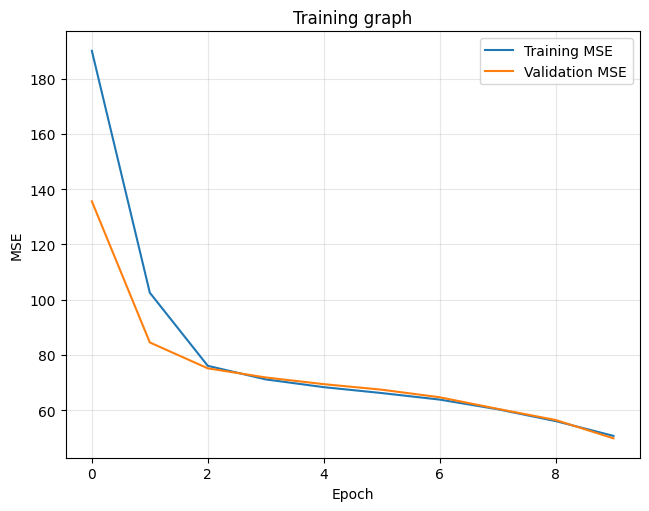

In [ ]:
#train the GRU model
gru_model = GRUModel(6,32)
gru_model_trained = train_model(gru_model, train_loader, test_loader, 10)

2024/11/20 19:26:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-midge-714 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/f6c5ed47fc7848b5bc5ce712e7ee14b7.
2024/11/20 19:26:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: f6c5ed47fc7848b5bc5ce712e7ee14b7
Epoch: 1 Training MSE: 155.3838 Validation MSE: 102.1334
Epoch: 6 Training MSE: 64.8796 Validation MSE: 66.0614


2024/11/20 19:27:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTMModel_19:26:39 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/9660bae2d113434680fe03172ece6751.
2024/11/20 19:27:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 19:28:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


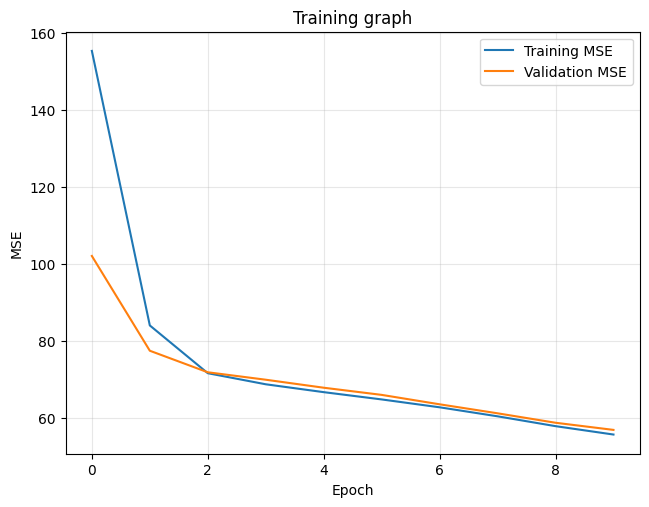

In [ ]:
#train the lstm model
lstm_model = LSTMModel(6,32,num_layers=1)
trained_lstm = train_model(lstm_model, train_loader, test_loader, 10)

2024/11/20 19:28:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-stag-579 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/851caa32b5954e1aad710a268e4fd496.
2024/11/20 19:28:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: 851caa32b5954e1aad710a268e4fd496
Epoch: 1 Training MSE: 106.2566 Validation MSE: 77.4917
Epoch: 6 Training MSE: 56.0301 Validation MSE: 55.3353


2024/11/20 19:33:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run SimpleRNN_19:28:01 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/15f35e7be67a43e1a51cae22becc5293.
2024/11/20 19:33:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 19:33:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


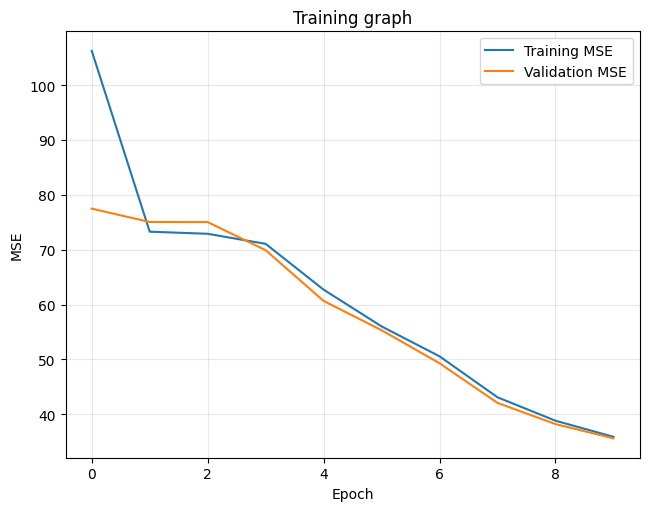

In [ ]:
#train the stacked rnn
stackedRNN = SimpleRNN(len(df.columns)-2, 64, num_layers=3)
trained_stacked_rnn = train_model(stackedRNN, train_loader, test_loader, 10)

### 4f) Finetune some pretrained model ###

In [ ]:
from transformers import BertConfig, BertModel

#setting up a bert for time series predictions
class TimeBERT(nn.Module):
    def __init__(self, input_dim, sequence_length, hidden_dim=128):
        super(TimeBERT, self).__init__()

        # BERT configuration
        self.bert_config = BertConfig(
            hidden_size=hidden_dim,
            num_attention_heads=4,
            num_hidden_layers=2,
            intermediate_size=hidden_dim * 4,
            max_position_embeddings=sequence_length,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
        )
        self.bert = BertModel(self.bert_config)

        # Feature embedding
        self.feature_embed = nn.Linear(input_dim, hidden_dim)

        # Output layer
        self.regressor = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()

        # Embed time-series features
        x = self.feature_embed(x)  

        # Reshape for BERT input
        x = x.view(batch_size, seq_len, -1) 

        # BERT encoding
        bert_output = self.bert(inputs_embeds=x)
        sequence_output = bert_output.last_hidden_state  

        cls_output = sequence_output[:, 0, :] 

        # Regression head
        output = self.regressor(cls_output)  

        return output

2024/11/20 19:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-shad-484 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/f04f939385984ef4bcb51785fe11574e.
2024/11/20 19:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: f04f939385984ef4bcb51785fe11574e
Epoch: 1 Training MSE: 79.7394 Validation MSE: 67.5932
Epoch: 6 Training MSE: 37.7583 Validation MSE: 36.7463


2024/11/20 19:43:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run TimeBERT_19:33:23 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/1d59bced1a0743d1ac061ecb29fa1782.
2024/11/20 19:43:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 19:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


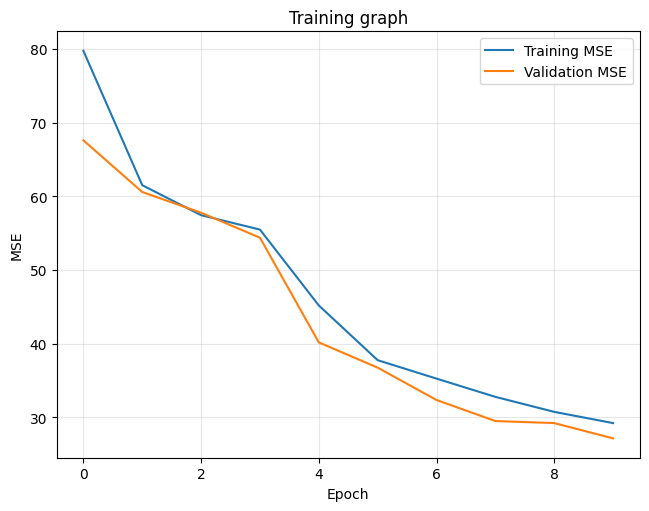

In [ ]:
#define and train the bert model
num_features = df.shape[1] - 2  
sequence_length = 24
bert_model = TimeBERT(input_dim=num_features, sequence_length=sequence_length)

trained_bertmodel = train_model(bert_model, train_loader, test_loader, 10)

### 6. Hyperparameter search ###

In [ ]:
#define objectve function to optimize hyperparameters
def objective(trial):

    #suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 8)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    #finetune the stacked rnn
    model = SimpleRNN(num_inputs=6, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    #iterate over epochs
    for epoch in range(10):
        model.train()
        for inputs, preds in train_loader:

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), preds)
            loss.backward()
            optimizer.step()

        mse = []

        for inputs, preds in test_loader:
            outputs = model(inputs)
            mse.append(criterion(outputs.squeeze(), preds).item())
        
    #return loss
    return (np.mean(mse))

In [ ]:
#perfrom the hyperparameter search with the optuna package
import logging
import os
import optuna
import sys
import sqlite3

optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))

# Define the path to the SQLite database
storage_directory = '../models/hyperparameter optimization'

# Create or load the study
study_name = "rnn_hyperparameter_optimization"

db_file_path = os.path.join(storage_directory, f'{study_name}.db')
storage_name = f'sqlite:///{os.path.join(storage_directory, f"{study_name}.db")}'

if not os.path.isfile(db_file_path):
    conn = sqlite3.connect(db_file_path)
    conn.close()

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True, 
    direction="minimize"
)

if not os.path.exists(db_file_path):
    study.optimize(objective, n_trials=16, n_jobs=2)

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best trial MSE:", study.best_value)

[I 2024-11-20 19:43:57,845] Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.


Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'dropout': 0.2970317684831742}
Best trial MSE: 30.8786673677077


2024/11/20 19:43:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-whale-758 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/d47fa7e4d02145c29a31730ab15d4bdf.
2024/11/20 19:43:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: d47fa7e4d02145c29a31730ab15d4bdf
Epoch: 1 Training MSE: 90.5793 Validation MSE: 75.0628
Epoch: 6 Training MSE: 42.3200 Validation MSE: 40.8945


2024/11/20 19:50:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run SimpleRNN_19:43:57 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/f5b632dcbc2c46d29dc4822cd08f42ce.
2024/11/20 19:50:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 19:50:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


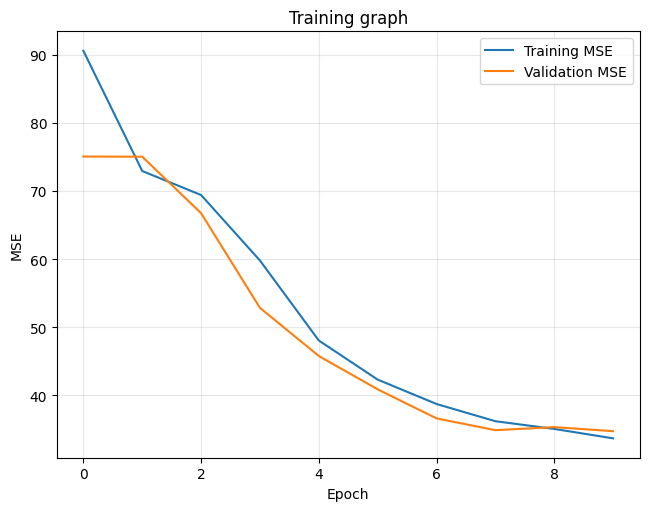

In [ ]:
#train a model with the best params found
params = study.best_params
hp_optim_model = SimpleRNN(num_inputs=6, hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout'])

trained_hp_model = train_model(hp_optim_model, train_loader, test_loader, 10)

In [ ]:
#define a function for model evaluation
def model_evaluation(models, dataloader):

    #define smape metric
    def smape(pred, actual):
        return 100 * torch.mean(2 * torch.abs(pred - actual) / (torch.abs(pred) + torch.abs(actual) + 1e-8)).item()

    #define R^2 metric
    def r2_score(pred, actual):
        ss_total = torch.sum((actual - torch.mean(actual)) ** 2)
        ss_residual = torch.sum((actual - pred) ** 2)
        return (1 - ss_residual / ss_total).item()

    #generate a result dataframe
    model_names = [f"{model.__class__.__name__}_{i}" for i, model in enumerate(models)]
    result_df = pd.DataFrame(columns=(['Metric'] + model_names))
    rows = []

    metrics = {
        'MSE': nn.MSELoss(),          # Mean Squared Error
        'MAE': nn.L1Loss(),           # Mean Absolute Error
        'SMAPE': smape,               # Symmetric Mean Absolute Percentage Error
        'R2': r2_score                # R-squared Score
    }
    #compute all metrics for all models
    for metric_name, metric_fn in metrics.items():
        row = {'Metric': metric_name}

        for i, model in enumerate(models):
            model.eval()  
            preds = []
            actuals = []

            with torch.no_grad():
                for sequences, targets in dataloader: 
                    if model.__class__.__name__ == 'BaselineModel':
                        preds.append(targets[1:])
                        actuals.append(targets[:-1])
                    else:
                        outputs = model(sequences)  # Get predictions
                        preds.append(outputs.squeeze())  # Squeeze for 1D compatibility
                        actuals.append(targets)

            preds = torch.cat(preds, dim=0)
            actuals = torch.cat(actuals, dim=0)

            # Compute metric
            unique_name = f"{model.__class__.__name__}_{i}"  # Unique column name for each model
            row[unique_name] = metric_fn(preds, actuals)

            #make sure all a float datatype
            if isinstance(row[unique_name], torch.Tensor):
                row[unique_name] = row[unique_name].item()

        #add row to list
        rows.append(row)  

    # Create a DataFrame from the list of rows
    result_df = pd.DataFrame(rows)
    return result_df

models = [baseline_model, trained_model, gru_model_trained, trained_lstm, trained_stacked_rnn, trained_hp_model, trained_bertmodel]

result_df = model_evaluation(models, test_loader)

In [ ]:
#distplay results of the model evaluation
display(result_df)

,Metric,BaselineModel_0,SimpleRNN_1,GRUModel_2,LSTMModel_3,SimpleRNN_4,SimpleRNN_5,TimeBERT_6
0,MSE,144.739777,58.513508,47.836060,54.387093,33.271225,32.048401,25.457123
1,MAE,9.296754,5.785478,5.061888,5.601780,4.098613,4.130245,3.701291
2,SMAPE,71.747363,48.080423,42.791241,46.460178,36.280873,36.486113,34.079149
3,R2,-0.986439,0.197161,0.343662,0.253778,0.543500,0.560278,0.650714
